In [1]:
# === Paso 1: Configuración inicial ===
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 4)

# === Cargar los datos ===
DATA_PATH = "Bank Customer Churn Prediction.csv"  # ajusta si tu CSV tiene otro nombre o ruta
df = pd.read_csv(DATA_PATH)

print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


X shape: (10000, 10)
y distribution:
churn
0    79.63
1    20.37
Name: proportion, dtype: float64


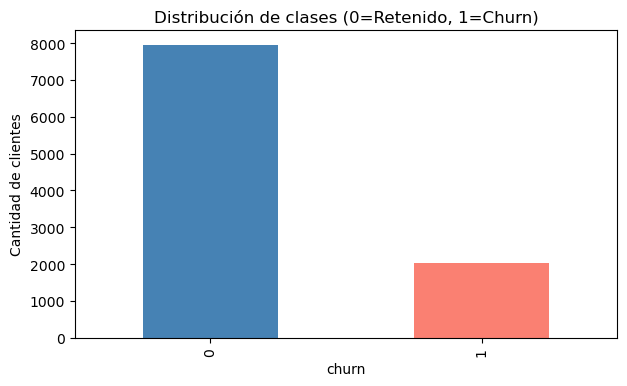

In [3]:

target_col = "churn" 

num_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
cat_cols = ['country', 'gender']
id_cols  = ['customer_id']


y = df[target_col]
X = df.drop(columns=[target_col] + id_cols)

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True) * 100)


y.value_counts().plot(kind='bar', color=['steelblue', 'salmon'])
plt.title("Distribución de clases (0=Retenido, 1=Churn)")
plt.ylabel("Cantidad de clientes")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)
print("Proporción de churn en train:", round(y_train.mean(), 3))
print("Proporción de churn en test:", round(y_test.mean(), 3))

numeric_proc = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_proc = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_proc, num_cols),
        ('cat', categorical_proc, cat_cols)
    ]
)

print("\nPreprocesador configurado correctamente")


Tamaño de entrenamiento: (8000, 10)
Tamaño de prueba: (2000, 10)
Proporción de churn en train: 0.204
Proporción de churn en test: 0.204

Preprocesador configurado correctamente


=== Regresión Logística (balanceada) ===
Matriz de confusión:
 [[1127  466]
 [ 127  280]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.8987    0.7075    0.7917      1593
           1     0.3753    0.6880    0.4857       407

    accuracy                         0.7035      2000
   macro avg     0.6370    0.6977    0.6387      2000
weighted avg     0.7922    0.7035    0.7294      2000

AUC: 0.7505 | F1: 0.4857 | Recall: 0.6880 | Precision: 0.3753 | Accuracy: 0.7035


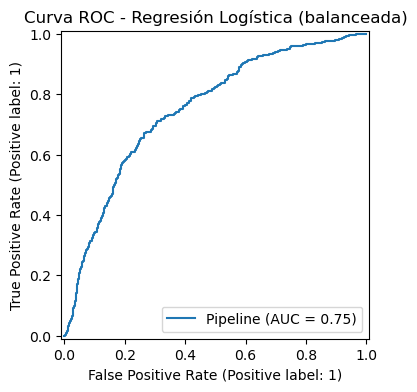

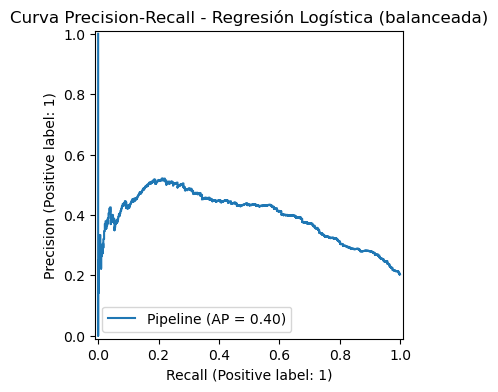

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

# === Modelo base: Regresión Logística ===
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # ajusta pesos automáticamente según el desbalance
    random_state=RANDOM_STATE
)

# Pipeline: preprocesamiento + modelo
pipe_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', logreg)
])

# Entrenar
pipe_lr.fit(X_train, y_train)

# Predicciones
y_pred = pipe_lr.predict(X_test)
y_prob = pipe_lr.predict_proba(X_test)

# === Evaluación ===
roc_auc = roc_auc_score(y_test, y_prob[:,1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("=== Regresión Logística (balanceada) ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))
print(f"AUC: {roc_auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}")

# === Curvas ROC y Precision-Recall ===
RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title("Curva ROC - Regresión Logística (balanceada)")
plt.show()

PrecisionRecallDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title("Curva Precision-Recall - Regresión Logística (balanceada)")
plt.show()


=== Random Forest (balanceado) ===
Matriz de confusión:
 [[1532   61]
 [ 234  173]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.8675    0.9617    0.9122      1593
           1     0.7393    0.4251    0.5398       407

    accuracy                         0.8525      2000
   macro avg     0.8034    0.6934    0.7260      2000
weighted avg     0.8414    0.8525    0.8364      2000

AUC: 0.8372 | F1: 0.5398 | Recall: 0.4251 | Precision: 0.7393 | Accuracy: 0.8525


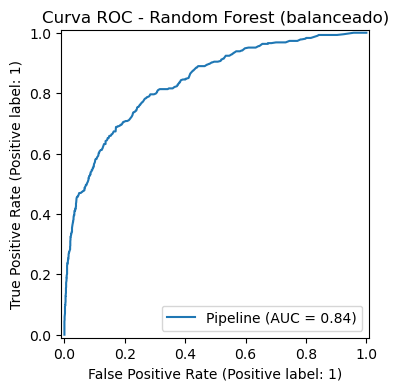

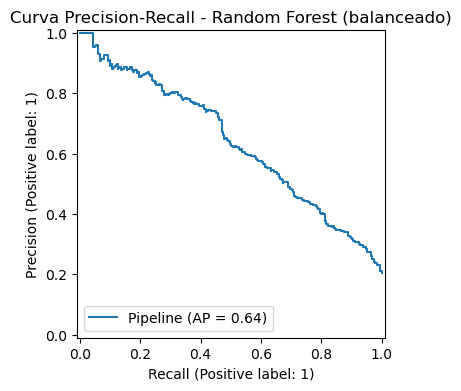

In [7]:
from sklearn.ensemble import RandomForestClassifier

# === Modelo: Random Forest (con pesos balanceados) ===
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight='balanced',   # maneja el desbalance interno
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline: preprocesamiento + modelo
pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf)
])

# Entrenamiento
pipe_rf.fit(X_train, y_train)

# Predicciones
y_pred = pipe_rf.predict(X_test)
y_prob = pipe_rf.predict_proba(X_test)

# === Evaluación ===
roc_auc = roc_auc_score(y_test, y_prob[:,1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("=== Random Forest (balanceado) ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))
print(f"AUC: {roc_auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}")

# === Curvas ROC y Precision-Recall ===
RocCurveDisplay.from_estimator(pipe_rf, X_test, y_test)
plt.title("Curva ROC - Random Forest (balanceado)")
plt.show()

PrecisionRecallDisplay.from_estimator(pipe_rf, X_test, y_test)
plt.title("Curva Precision-Recall - Random Forest (balanceado)")
plt.show()


=== Random Forest + ADASYN ===
Matriz de confusión:
 [[1382  211]
 [ 157  250]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.8980    0.8675    0.8825      1593
           1     0.5423    0.6143    0.5760       407

    accuracy                         0.8160      2000
   macro avg     0.7201    0.7409    0.7293      2000
weighted avg     0.8256    0.8160    0.8201      2000

AUC: 0.8267 | F1: 0.5760 | Recall: 0.6143 | Precision: 0.5423 | Accuracy: 0.8160


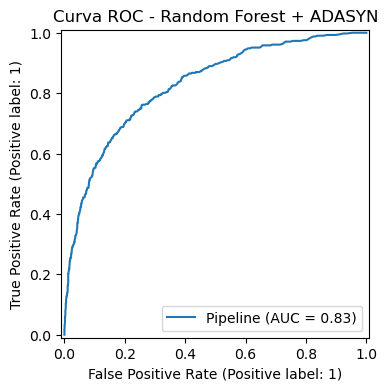

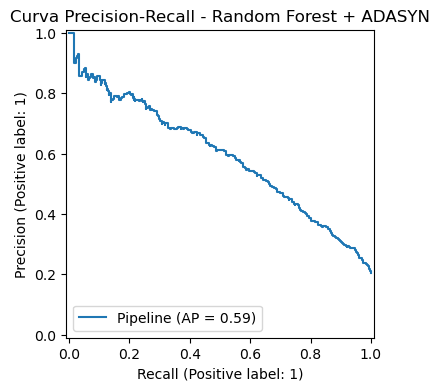

In [8]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# === ADASYN + Random Forest ===
adasyn = ADASYN(random_state=RANDOM_STATE)
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline: preprocesamiento + sobremuestreo + modelo
pipe_rf_adasyn = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('adasyn', adasyn),
    ('model', rf)
])

# Entrenamiento
pipe_rf_adasyn.fit(X_train, y_train)

# Predicciones
y_pred = pipe_rf_adasyn.predict(X_test)
y_prob = pipe_rf_adasyn.predict_proba(X_test)

# === Evaluación ===
roc_auc = roc_auc_score(y_test, y_prob[:,1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("=== Random Forest + ADASYN ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))
print(f"AUC: {roc_auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}")

# === Curvas ROC y Precision-Recall ===
RocCurveDisplay.from_estimator(pipe_rf_adasyn, X_test, y_test)
plt.title("Curva ROC - Random Forest + ADASYN")
plt.show()

PrecisionRecallDisplay.from_estimator(pipe_rf_adasyn, X_test, y_test)
plt.title("Curva Precision-Recall - Random Forest + ADASYN")
plt.show()


=== Random Forest + SMOTEENN ===
Matriz de confusión:
 [[1257  336]
 [ 109  298]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9202    0.7891    0.8496      1593
           1     0.4700    0.7322    0.5725       407

    accuracy                         0.7775      2000
   macro avg     0.6951    0.7606    0.7111      2000
weighted avg     0.8286    0.7775    0.7932      2000

AUC: 0.8324 | F1: 0.5725 | Recall: 0.7322 | Precision: 0.4700 | Accuracy: 0.7775


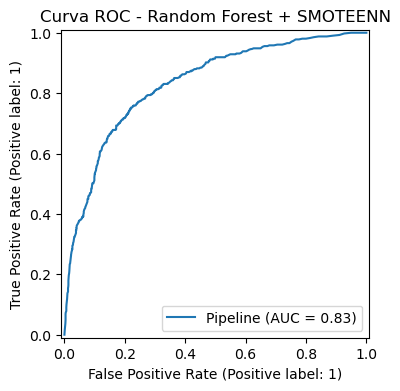

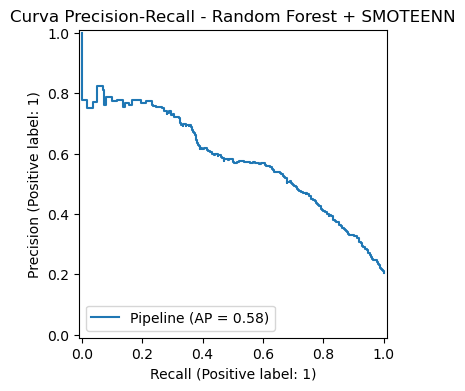

In [9]:
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# === SMOTEENN + Random Forest ===
smoteenn = SMOTEENN(random_state=RANDOM_STATE)
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline: preprocesamiento + re-muestreo + modelo
pipe_rf_smoteenn = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smoteenn', smoteenn),
    ('model', rf)
])

# Entrenamiento
pipe_rf_smoteenn.fit(X_train, y_train)

# Predicciones
y_pred = pipe_rf_smoteenn.predict(X_test)
y_prob = pipe_rf_smoteenn.predict_proba(X_test)

# === Evaluación ===
roc_auc = roc_auc_score(y_test, y_prob[:,1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("=== Random Forest + SMOTEENN ===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))
print(f"AUC: {roc_auc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}")

# === Curvas ROC y Precision-Recall ===
RocCurveDisplay.from_estimator(pipe_rf_smoteenn, X_test, y_test)
plt.title("Curva ROC - Random Forest + SMOTEENN")
plt.show()

PrecisionRecallDisplay.from_estimator(pipe_rf_smoteenn, X_test, y_test)
plt.title("Curva Precision-Recall - Random Forest + SMOTEENN")
plt.show()


In [ ]:
import mlflow
import mlflow.sklearn

# === Configuración local de MLflow ===
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # luego cambiar por la IP pública
mlflow.set_experiment("bank-churn-local-tests")

print("Configuración de MLflow lista  (modo local)")


In [ ]:
def registrar_en_mlflow(nombre_modelo, modelo_pipeline, metricas, parametros=None):
    """
    Registra un modelo y sus métricas en MLflow.
    nombre_modelo: string (ej. "RandomForest_SMOTEENN")
    modelo_pipeline: pipeline completo (preprocesamiento + modelo)
    metricas: diccionario con métricas { 'AUC': ..., 'F1': ..., etc. }
    parametros: opcional, diccionario con parámetros del modelo
    """
    with mlflow.start_run(run_name=nombre_modelo):
        # Parámetros del modelo
        if parametros:
            for k, v in parametros.items():
                mlflow.log_param(k, v)
        else:
            try:
                for k, v in modelo_pipeline.named_steps['model'].get_params().items():
                    mlflow.log_param(k, v)
            except Exception as e:
                print("No se pudieron registrar parámetros:", e)

        # Métricas
        for k, v in metricas.items():
            mlflow.log_metric(k, float(v))

        # Guardar el modelo completo
        mlflow.sklearn.log_model(modelo_pipeline, artifact_path=f"model_{nombre_modelo}")

        print(f"✅ Modelo '{nombre_modelo}' registrado correctamente en MLflow.")


In [ ]:
metricas = {
    "AUC": roc_auc,
    "F1": f1,
    "Recall": recall,
    "Precision": precision,
    "Accuracy": accuracy
}

registrar_en_mlflow("RandomForest_SMOTEENN", pipe_rf_smoteenn, metricas)


In [ ]:
registrar_en_mlflow("RandomForest_ADASYN", pipe_rf_adasyn, metricas_adasyn)
registrar_en_mlflow("LogReg_Balanceada", pipe_lr, metricas_logreg)
